# Transformer Solutions

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from train_transformers import GRID_SIZE, MAX_PATH_LENGTH, D_MODEL, N_HEAD, N_ENCODER, N_DECODER, FC_DIM, SHORTEST_PATH
from maze_dataset import MazeDatasetSequential
from maze_util import GO, MOVE_START, CELL_SIZE, valid_move, draw_moves_on_grid
from Solver import TransformerSolver
import matplotlib

DEVICE = 'cpu'
SEED   = 42

In [2]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

@torch.no_grad()
def solve_with_transformer(solver, in_seq, start_token):
    solver.eval()
    grid = np.zeros((GRID_SIZE*CELL_SIZE,GRID_SIZE*CELL_SIZE))
    idx = 0
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            grid[i*CELL_SIZE:i*CELL_SIZE+CELL_SIZE,j*CELL_SIZE:j*CELL_SIZE+CELL_SIZE] = in_seq[0,idx][:CELL_SIZE*CELL_SIZE].reshape(CELL_SIZE,CELL_SIZE)
            idx+=1

    x = in_seq.to(DEVICE)
    y_in = start_token.to(DEVICE)
    moves = [MOVE_START]

    cr, cc = int(y_in[0,0,2].item()), int(y_in[0,0,3].item())
    route = [(cr, cc)]
    move_cnt = 0
    while move_cnt < MAX_PATH_LENGTH-1:
        pred = solver(x, y_in, mask=False)
        _, predicted = torch.max(pred.reshape(-1,5), 1)
        predicted = predicted[-1].item()

        if not valid_move(grid, cr, cc, predicted):
            break

        moves.append(predicted)
        move_cnt += 1
        new_y = torch.zeros_like(y_in[0,0])
        new_y[0] = predicted
        new_y[1] = move_cnt
        dm = GO[predicted]
        cr = cr + dm[0]
        cc = cc + dm[1]
        new_y[2] = cr
        new_y[3] = cc

        y_in = torch.concat([y_in, new_y.unsqueeze(dim=0).unsqueeze(dim=0)], dim=1)
        route.append((cr,cc))

        if predicted == 0:
            break
            
    return moves, route

In [3]:
test_dataset = MazeDatasetSequential(30, GRID_SIZE, MAX_PATH_LENGTH, D_MODEL, SHORTEST_PATH)
solver = TransformerSolver(d_model=D_MODEL, nhead=N_HEAD, num_encoder_layers=N_ENCODER, num_decoder_layers=N_DECODER, dim_feedforward=FC_DIM, batch_first=True)
solver = solver.to(DEVICE)
load_res = solver.load_state_dict(torch.load(f"./transformer_solver_best.pt", map_location=DEVICE))

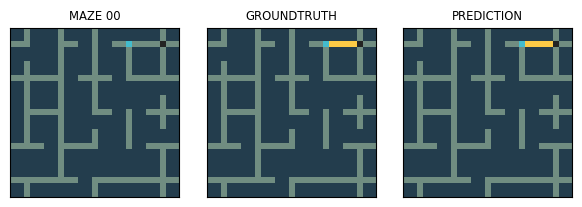

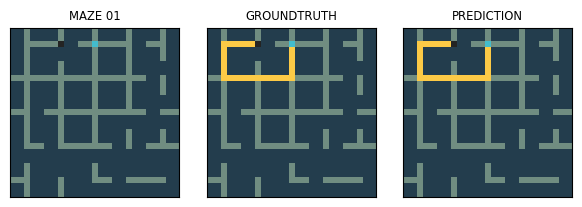

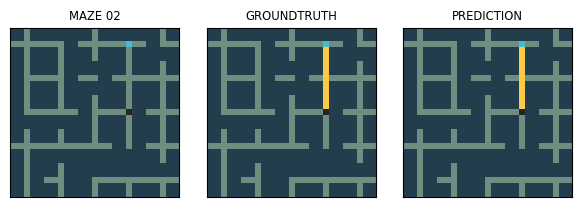

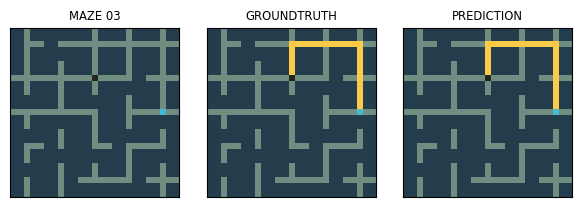

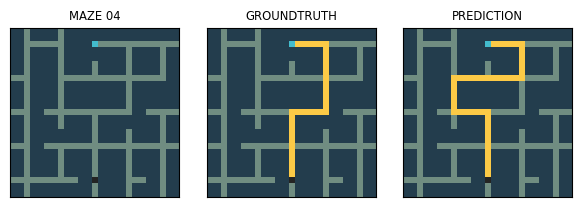

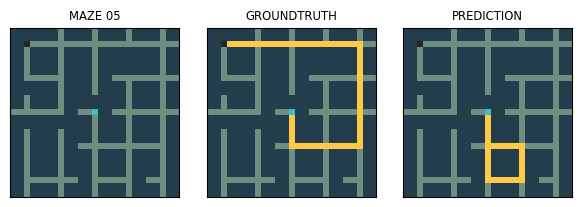

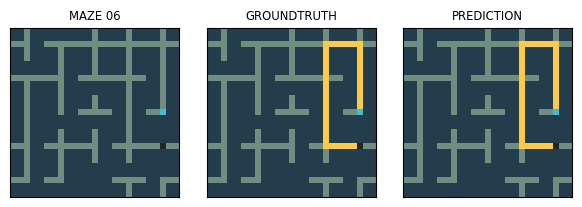

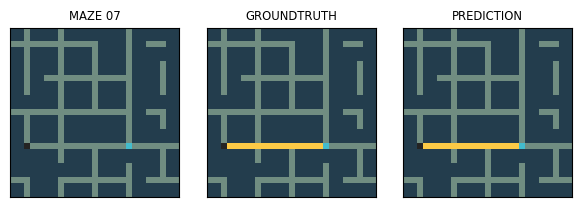

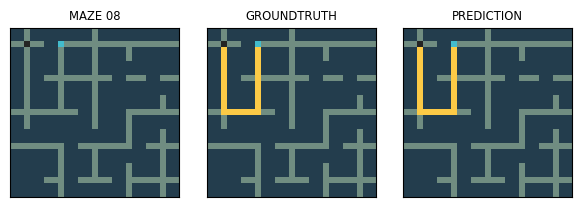

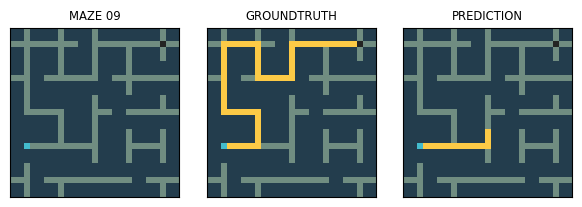

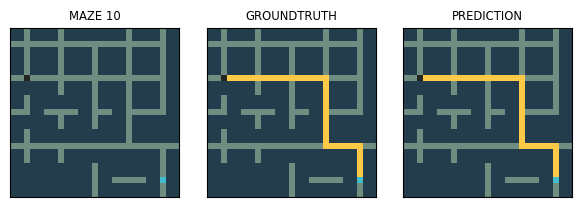

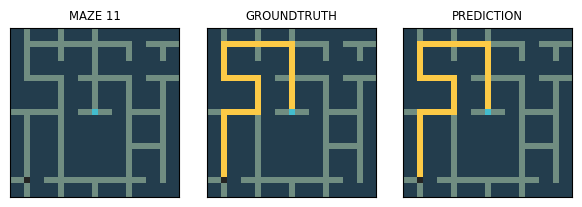

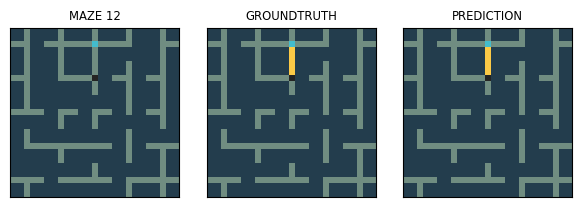

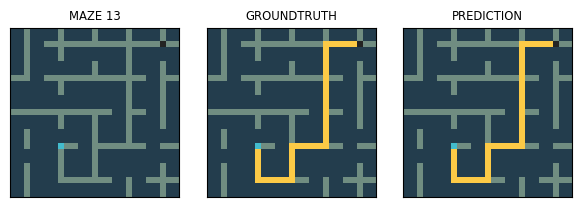

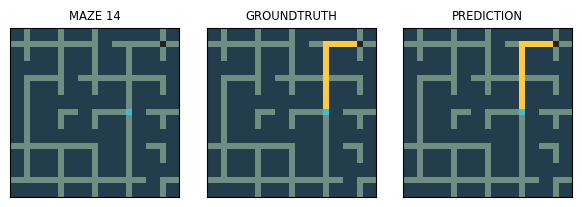

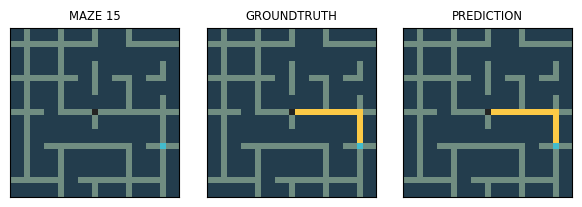

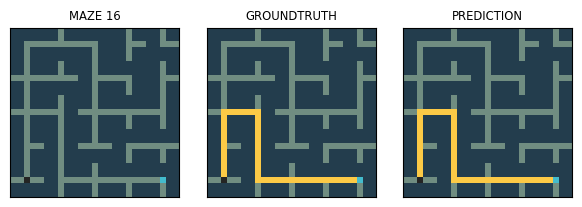

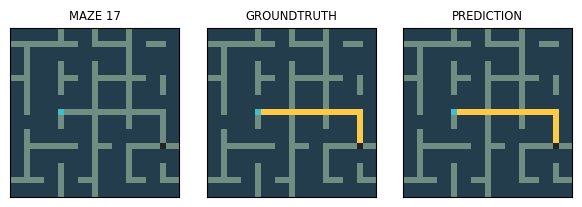

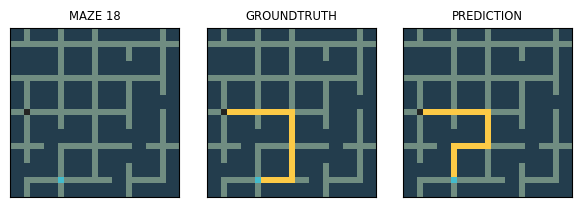

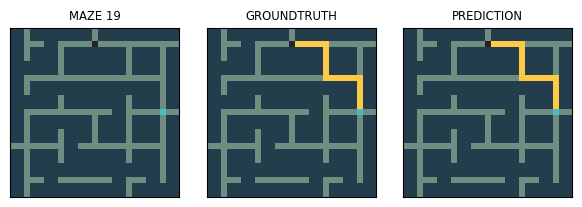

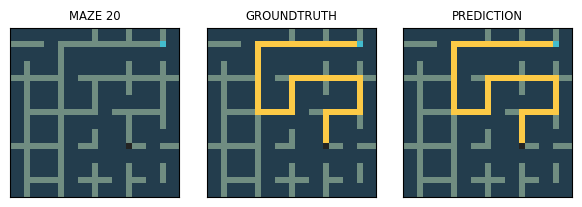

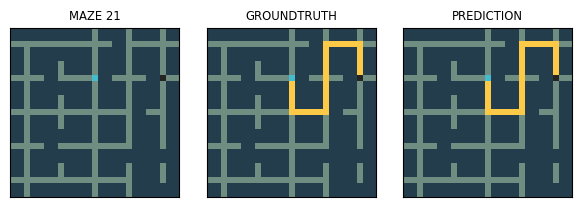

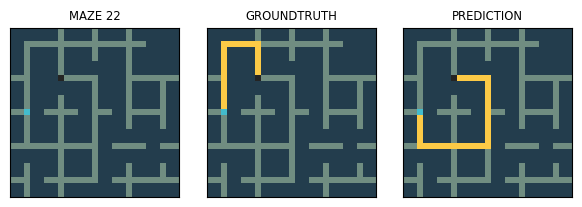

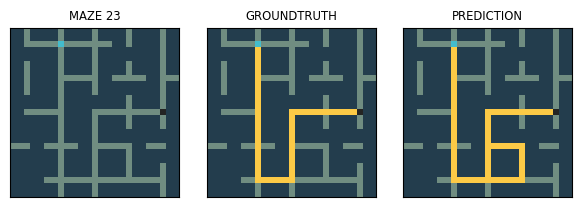

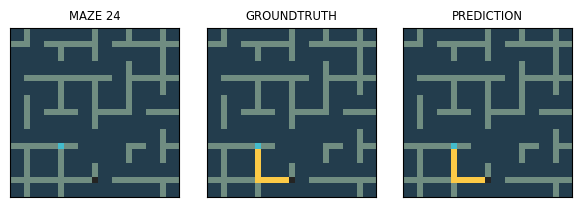

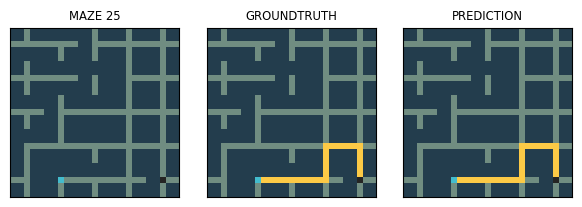

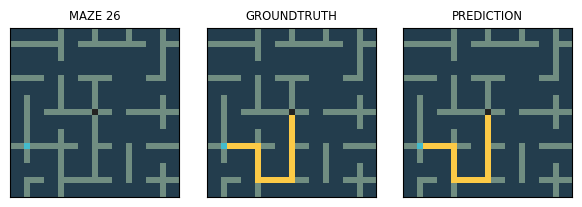

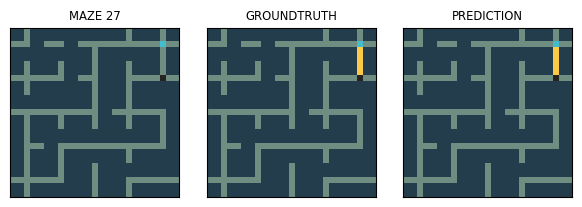

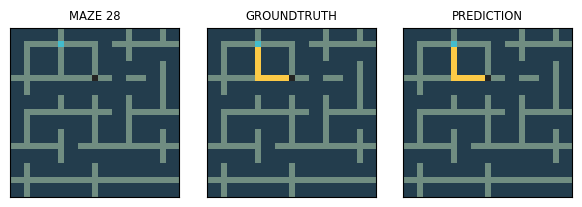

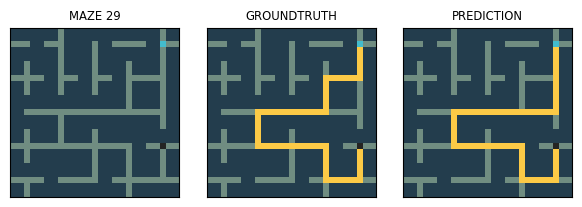

In [4]:
for mid in range(30):
    matplotlib.rcParams.update({'font.size': 7})
    in_seq, out_seq, start_tile, end_tile = test_dataset[mid]
    gt_moves = out_seq[:,0].numpy()
    pred_moves, pred_route = solve_with_transformer(solver, in_seq.unsqueeze(dim=0), out_seq[0].unsqueeze(dim=0).unsqueeze(dim=0))
    
    maze      = test_dataset.sequence_to_grid(in_seq).numpy()
    maze_gt   = draw_moves_on_grid(maze, gt_moves, *start_tile, *end_tile)
    maze_pred = draw_moves_on_grid(maze, pred_moves, *start_tile, *end_tile)

    fig, axes = plt.subplots(1, 3, squeeze=False, figsize=(6,2))
    cmap = matplotlib.colors.ListedColormap(['#233d4d', '#708d81', '#43bccd', '#242423','#fcca46'])
    bounds=[0,1,2,3,4,5]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    axes[0,0].matshow(maze, cmap=cmap, norm=norm)
    axes[0,0].set_title(f"MAZE {mid:02d}")
    axes[0,1].matshow(maze_gt, cmap=cmap, norm=norm)
    axes[0,1].set_title("GROUNDTRUTH")
    axes[0,2].matshow(maze_pred, cmap=cmap, norm=norm)
    axes[0,2].set_title("PREDICTION")

    for i in range(3):
        axes[0,i].set_xticks([])
        axes[0,i].set_xticklabels([])
        axes[0,i].set_yticks([])
        axes[0,i].set_yticklabels([])
    plt.tight_layout()
    plt.show()

# CNN Solution

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from train_cnns import GRID_SIZE, MAX_PATH_LENGTH, D_MODEL, FC_DIM, SHORTEST_PATH
from maze_dataset import MazeDatasetSnapshots, MazeDatasetSnapshotsTest
from maze_util import GO, MOVE_START, valid_move, draw_moves_on_grid
from Solver import CNNSolver
import matplotlib

DEVICE = 'cpu'
SEED   = 42

In [6]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

@torch.no_grad()
def solve_with_cnn(solver, maze, sr, sc):
    solver.eval()
    grid = maze.clone()
    numpy_grid = grid.numpy()

    x = grid.to(DEVICE)
    moves = [MOVE_START]
    cr, cc = sr, sc
    route = [(cr, cc)]
    move_cnt = 0

    while move_cnt < MAX_PATH_LENGTH-1:
        pred = solver(x.unsqueeze(0))
        _, predicted = torch.max(pred, 1)
        predicted = predicted[-1].item()

        if not valid_move(numpy_grid, cr, cc, predicted):
            break

        moves.append(predicted)
        MazeDatasetSnapshots.add_move_to_grid(x, cr, cc, predicted)
        
        move_cnt += 1
        dm = GO[predicted]
        cr = cr + dm[0]
        cc = cc + dm[1]

        route.append((cr,cc))

        if predicted == 0:
            break
            
    return moves, route

In [7]:
test_dataset = MazeDatasetSnapshotsTest(30, GRID_SIZE, MAX_PATH_LENGTH, SHORTEST_PATH)
solver = CNNSolver(d_model=D_MODEL, dim_feedforward=FC_DIM)
solver = solver.to(DEVICE)
load_res = solver.load_state_dict(torch.load(f"./cnn_solver_best.pt", map_location=DEVICE))
solver = solver.double()

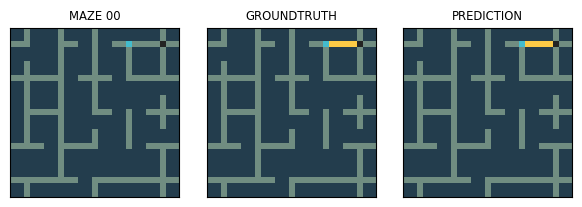

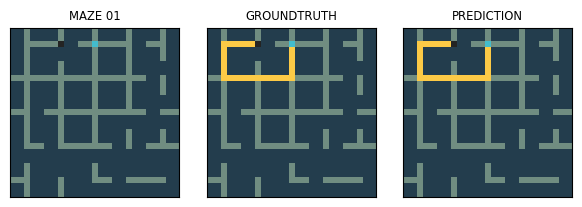

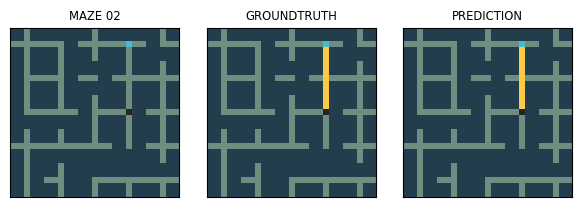

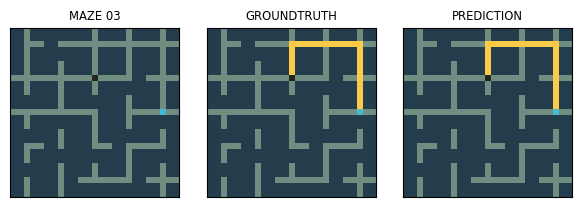

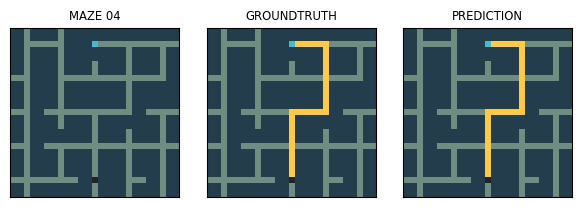

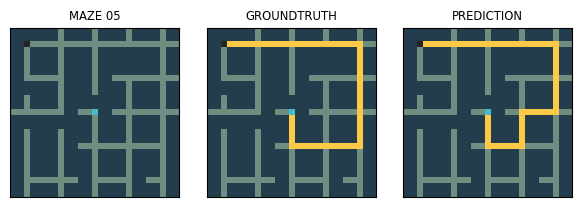

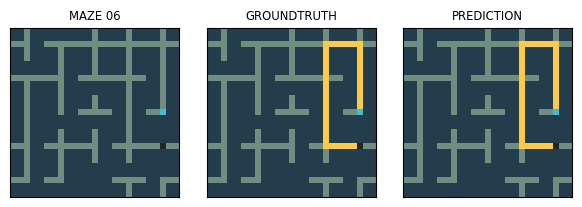

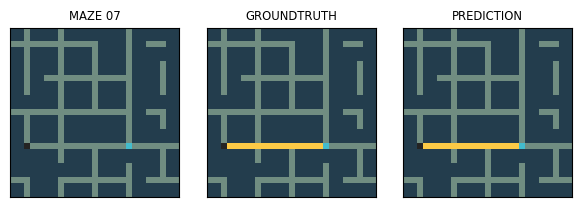

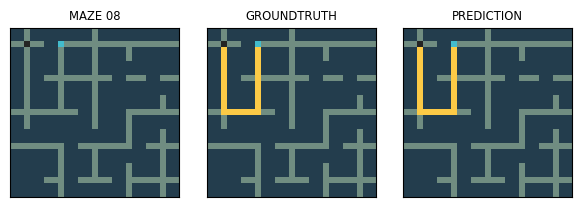

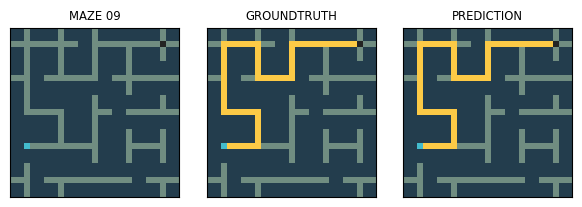

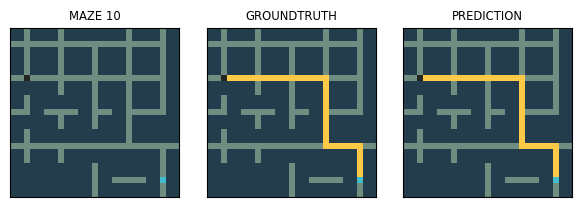

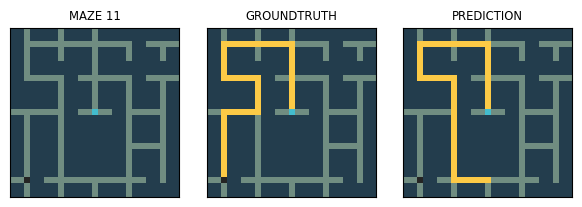

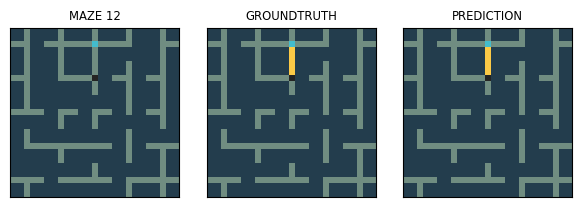

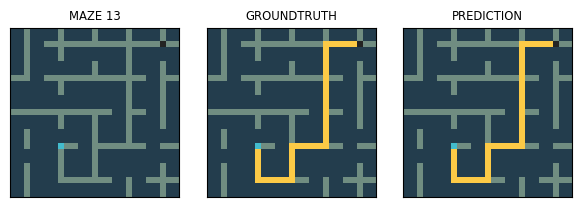

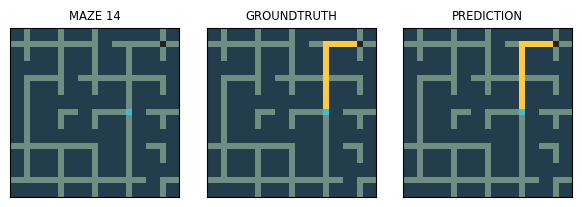

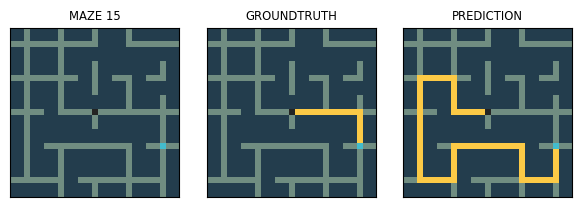

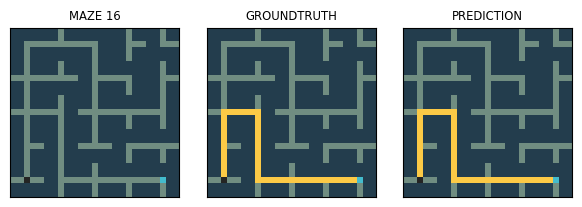

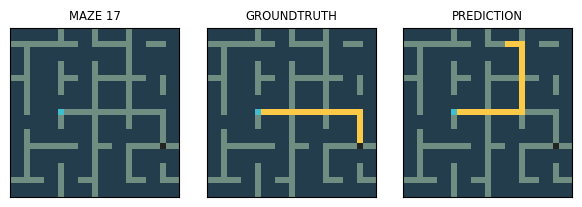

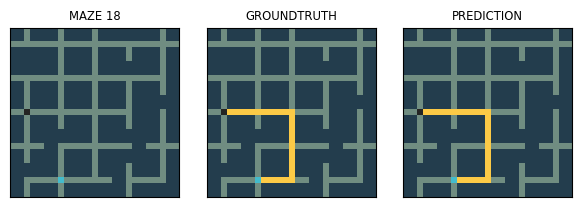

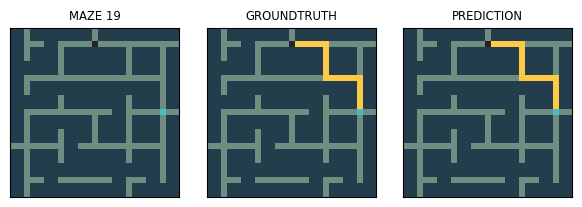

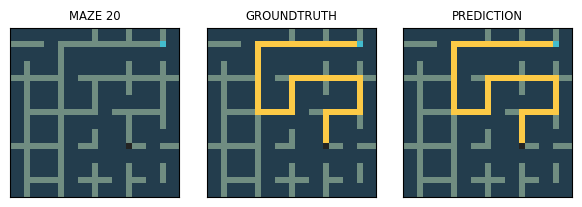

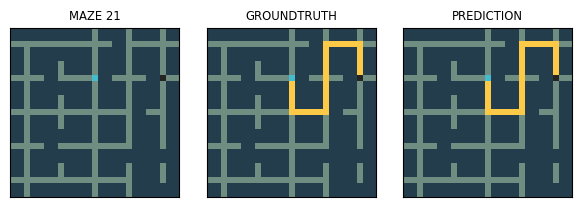

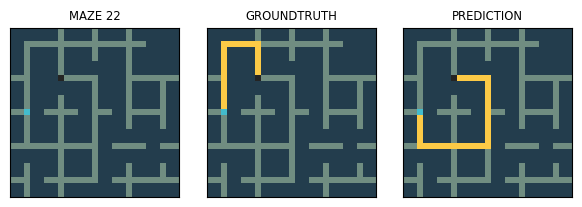

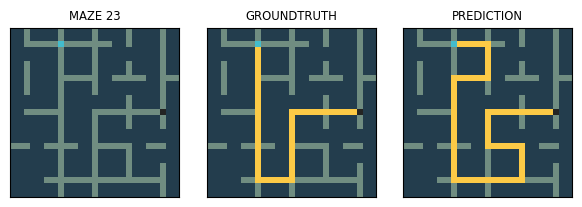

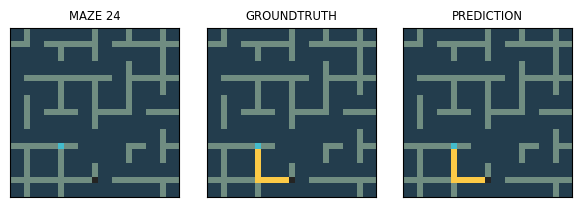

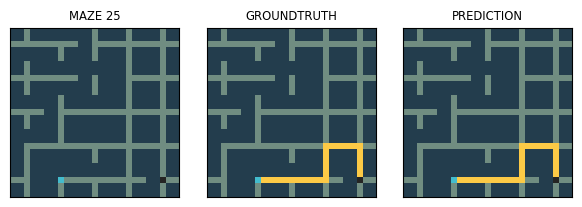

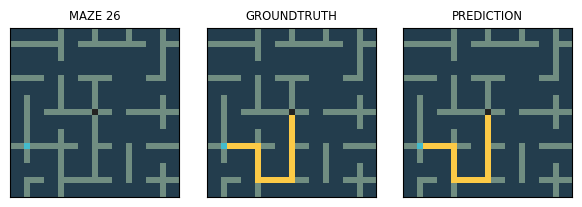

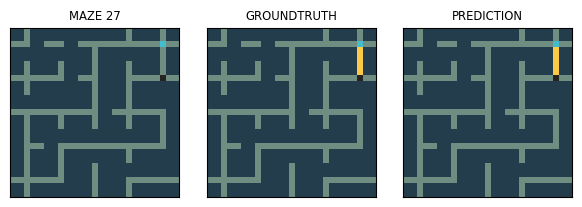

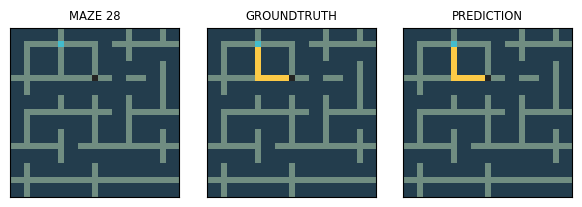

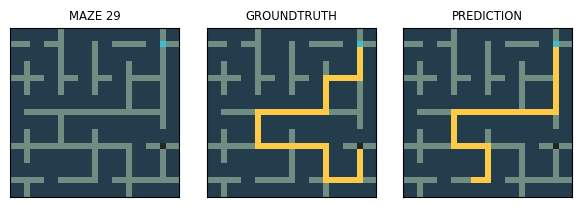

In [8]:
for mid in range(30):
    matplotlib.rcParams.update({'font.size': 7})
    maze, maze_gt, start_tile, end_tile = test_dataset[mid]
    pred_moves, pred_route = solve_with_cnn(solver, maze, start_tile[0], start_tile[1])
    maze = maze.squeeze().numpy()
    maze_gt = maze_gt.squeeze().numpy()
    maze_pred = draw_moves_on_grid(maze, pred_moves, *start_tile, *end_tile)

    fig, axes = plt.subplots(1, 3, squeeze=False, figsize=(6,2))
    cmap = matplotlib.colors.ListedColormap(['#233d4d', '#708d81', '#43bccd', '#242423','#fcca46'])
    bounds=[0,1,2,3,4,5]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    axes[0,0].matshow(maze, cmap=cmap, norm=norm)
    axes[0,0].set_title(f"MAZE {mid:02d}")
    axes[0,1].matshow(maze_gt, cmap=cmap, norm=norm)
    axes[0,1].set_title("GROUNDTRUTH")
    axes[0,2].matshow(maze_pred, cmap=cmap, norm=norm)
    axes[0,2].set_title("PREDICTION")

    for i in range(3):
        axes[0,i].set_xticks([])
        axes[0,i].set_xticklabels([])
        axes[0,i].set_yticks([])
        axes[0,i].set_yticklabels([])
    plt.tight_layout()
    plt.show()